In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from fastai.vision import *
import torch

In [3]:
LABELS_FILE = 'trainLabels.csv'
DATA_DIR = 'train'
TRAIN_CLASS_SAMPLES = 4000
SMALL_DATA_PREFIX = '/home/pcheng/Desktop/train/small'
USE_SMALL=True

In [4]:
def seedAll(seed = 0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)


In [5]:
%%bash -s "{DATA_DIR}" "{SMALL_DATA_PREFIX}"
# Create smaller image files for speed
size=224
srcdir="$1"
dstdir="$2"_"$size"
dstsize="$size"x"$size"^
echo "$dstdir"
if [ ! -d "$dstdir" ]; then
    mkdir -p "$dstdir"
    parallel mogrify -resize "$dstsize" -path "$dstdir" ::: "$srcdir"/*.jpeg
fi

/home/pcheng/Desktop/train/small_224


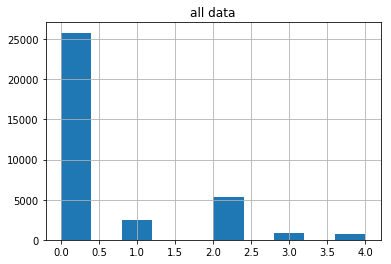

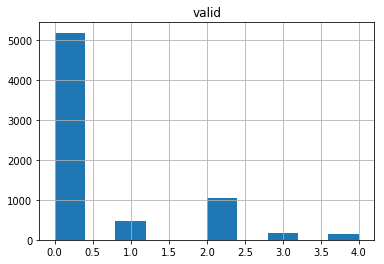

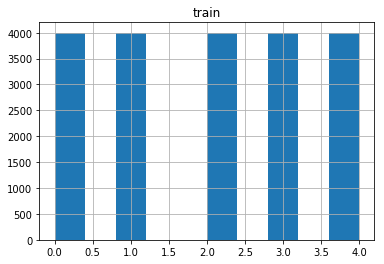

In [6]:
# Load data
data = pd.read_csv(os.path.join(DATA_DIR, LABELS_FILE), delimiter=',')
data.hist()
plt.title('all data')

# Split out a validation set, then create a training set with balanced labels

# First randomly shuffle the data
seedAll()
data = data.reindex(np.random.permutation(data.index))

# Use first 20% as validation directly
valid_idx = range(0, len(data) // 5)
valid_data = data.iloc[valid_idx]
valid_data.hist()
plt.title('valid')

# Sample images from each class
non_valid_data = data.drop(valid_idx)
train_class_samples = []
for label, group in non_valid_data.groupby('level'):
    class_sample = group.sample(TRAIN_CLASS_SAMPLES, replace = (len(group) < TRAIN_CLASS_SAMPLES))
    train_class_samples.append(class_sample)
train_data = pd.concat(train_class_samples)
train_data.hist()
plt.title('train')

# Concatenate back together to pass to fastai
valid_train_data = pd.concat([valid_data, train_data])

In [7]:
def loadData(image_size, batch_size):
    data_dir = f'{SMALL_DATA_PREFIX}_{image_size}' if USE_SMALL else DATA_DIR
    return ImageItemList.from_df(valid_train_data, data_dir, suffix='.jpeg') \
                       .split_by_idx(valid_idx) \
                       .label_from_df() \
                       .transform(get_transforms(), size=image_size) \
                       .databunch(bs=batch_size) \
                       .normalize(imagenet_stats)

In [8]:
data = loadData(224, 32)

In [9]:
# Kaggle uses quadratic weighted kappa
kappa = KappaScore()
kappa.weights = "quadratic"
learn = create_cnn(data, models.resnet50, metrics=[error_rate, kappa])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


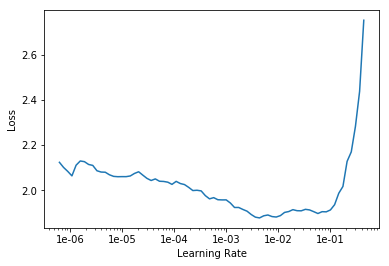

In [10]:
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(4, max_lr=1e-3)
learn.save('finetuned-224-4')

epoch,train_loss,valid_loss,error_rate,kappa_score
1,1.267879,1.098843,0.461495,0.192430
2,1.077205,1.186140,0.540641,0.184995
3,0.972655,1.103021,0.547189,0.204310
4,0.906440,1.061121,0.503488,0.229207


In [12]:
learn.fit_one_cycle(4, max_lr=1e-3)
learn.save('finetuned-224-8')

epoch,train_loss,valid_loss,error_rate,kappa_score
1,0.920909,1.123293,0.569395,0.193693
2,0.934635,1.114042,0.562420,0.196113
3,0.810144,0.993269,0.464057,0.261160
4,0.766907,1.038159,0.507331,0.241483


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


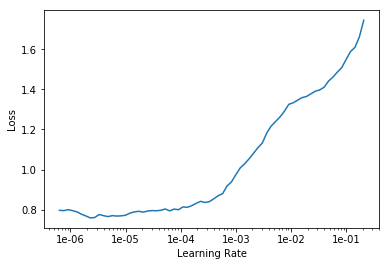

In [13]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(4, max_lr=1e-5)

epoch,train_loss,valid_loss,error_rate,kappa_score
1,0.786548,1.022661,0.495658,0.253702
2,0.730900,0.916937,0.439288,0.293902
3,0.688054,0.957050,0.464057,0.283544
4,0.662999,0.968182,0.485552,0.272672


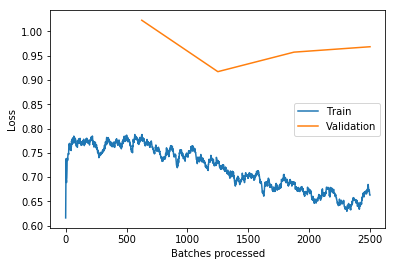

In [15]:
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,error_rate,kappa_score
1,0.658808,0.956852,0.475018,0.276398
2,0.634637,0.864673,0.406690,0.326199
3,0.609868,0.921357,0.446975,0.307324
4,0.587924,0.925697,0.439146,0.314245


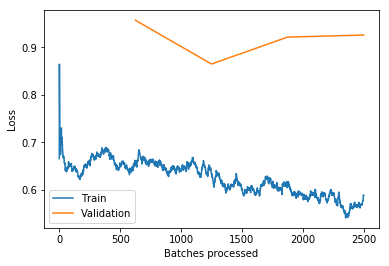

In [16]:
learn.fit_one_cycle(4, max_lr=1e-5)
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


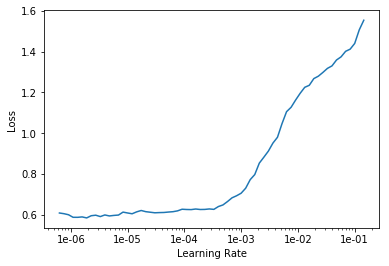

In [17]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,kappa_score
1,0.570904,0.906241,0.432171,0.320648
2,0.571504,0.908084,0.430605,0.322191
3,0.551755,0.886193,0.405694,0.343121
4,0.560295,0.872045,0.408399,0.338243
5,0.542039,0.974436,0.471744,0.298942
6,0.521484,0.865167,0.402989,0.348105
7,0.475406,0.894596,0.393737,0.367890
8,0.484903,0.850524,0.372669,0.385584
9,0.432190,0.734217,0.312171,0.441705
10,0.381981,0.767024,0.319146,0.444577


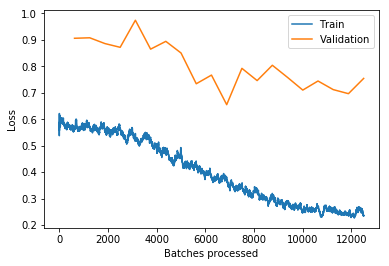

In [18]:
learn.save('checkpoint1')
learn.fit_one_cycle(20, max_lr=1e-5)
learn.recorder.plot_losses()
learn.save('checkpoint2')

epoch,train_loss,valid_loss,error_rate,kappa_score
1,0.230860,0.793512,0.315160,0.461671
2,0.247721,0.804126,0.312171,0.464585
3,0.244930,0.718711,0.277722,0.502501
4,0.261705,0.692126,0.261495,0.519763
5,0.260612,0.785165,0.302206,0.472253
6,0.263992,0.653094,0.241566,0.540920
7,0.252837,0.946175,0.345623,0.433101
8,0.218189,0.750735,0.278577,0.504692
9,0.208682,0.752218,0.275445,0.508667
10,0.209819,0.769963,0.269893,0.514594


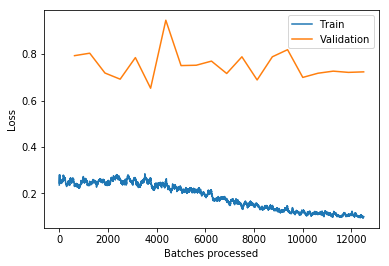

In [19]:
learn.fit_one_cycle(20, max_lr=1e-5)
learn.recorder.plot_losses()
learn.save('checkpoint3')

epoch,train_loss,valid_loss,error_rate,kappa_score
1,0.111792,0.750214,0.249680,0.545510
2,0.109381,0.762064,0.256797,0.535459
3,0.125833,0.760971,0.248826,0.546047
4,0.139402,0.779434,0.250534,0.541973
5,0.130782,0.901876,0.285979,0.502245
6,0.136951,0.768933,0.246263,0.548267
7,0.154961,0.680629,0.220071,0.578885
8,0.129748,0.784672,0.245125,0.547901
9,0.130598,0.962371,0.301495,0.483316
10,0.126151,0.749447,0.226619,0.572494


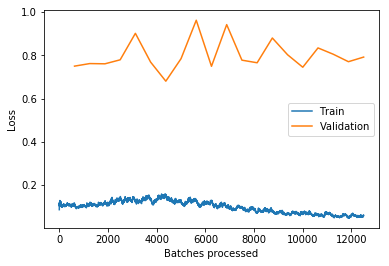

In [20]:
learn.fit_one_cycle(20, max_lr=1e-5)
learn.recorder.plot_losses()
learn.save('checkpoint4')